### Importação de bibliotecas python

In [1]:
import os
import numpy as np
import pandas as pd
import neptune
import json
from datetime import datetime
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,make_scorer,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
from sklearn.metrics import mean_squared_log_error as mslee

### Importação de módulos do projeto

In [3]:
os.chdir("..")

from src.utils import load_settings
from src.submission import KaggleSubmission
from src.train import KaggleTrain

### Load Settings

In [4]:
settings = load_settings()

In [5]:
id_column        = settings["id_column"]
target_column    = settings["target_column"]
competition_name = settings["competition_name"]

### Read Data

In [6]:
train = pd.read_csv("data/train.csv")

In [7]:
test = pd.read_csv("data/test.csv")

### Exploratory Analysis

In [8]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
!cat data/data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

### Análise descritiva

In [10]:
variavel_analise = 'BsmtFullBath'

In [11]:
DescribeCount = test.\
    fillna('missing').\
    groupby([variavel_analise])['Id'].\
    describe()[['count']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,BsmtFullBath,count
0,0,849.0
1,1,584.0
2,2,23.0
3,3,1.0
4,missing,2.0


In [12]:
DescribeCount = train.\
    fillna('missing').\
    groupby([variavel_analise])['SalePrice'].\
    describe()[['mean', 'count', 'std', 'min', 'max']].\
    apply(lambda x: round(x, 1)).\
    reset_index()

DescribeCount

,BsmtFullBath,mean,count,std,min,max
0,0,165521.6,856.0,68137.8,34900.0,755000.0
1,1,202522.9,588.0,88895.9,35311.0,745000.0
2,2,213063.1,15.0,87308.2,108959.0,385000.0
3,3,179000.0,1.0,NaN,179000.0,179000.0


### Feature Engineering

In [13]:
dataprep_list =\
{
    "factor_to_number":{"ExterCond":{
                            "order": ["Ex", "Gd", "TA", "Fa", "Po"],
                            "grade": [5,4,3,2,1]},
                        "ExterQual":{                            
                            "order": ["Ex", "Gd", "TA", "Fa", "Po"],
                            "grade": [5,4,3,2,1]},
                        "LotShape":{
                            "order": ['Reg', 'IR1', 'IR2', 'IR3'],
                            "grade": [4,3,2,1]},
                        "LandSlope":{
                            "order": ['Gtl', 'Mod', 'Sev'],
                            "grade": [3,2,1]},
                        "LandContour":{
                            "order": ['Lvl', 'Bnk', 'HLS', 'Low'],
                            "grade": [4,3,2,1]},
                        "HeatingQC":{
                             "order": ["Ex", "Gd", "TA", "Fa", "Po"],
                            "grade": [5,4,3,2,1]},

                       },   
    "scale_adjust": {"YrSold": {"value": -2010}},
    "continuous_to_binary": {"PoolArea": {"threshold": 0}},  
    "identity": ["LotArea", "OverallQual", "OverallCond", "Fireplaces", "KitchenAbvGr"],
    "missing_class": ["Alley", "MasVnrType"],
    "missing_number_to_inf": ["LotFrontage", "BsmtFullBath"],
    "binary_dummies": ["Street", 
                       "Alley", 
                       "SaleCondition", 
                       "LandSlope", 
                       "CentralAir", 
                       "KitchenQual",
                       "Foundation",
                       "MSSubClass",
                       "MSZoning",
                       "LotConfig",
                       "Neighborhood",
                       "BldgType",
                       "RoofStyle",
                       "MasVnrType"
                      ]
}

In [14]:
def feature_eng(data, dataprep_list):
    
    X_columns = []
    
    # Missing to classes
    data[dataprep_list["missing_class"]] = data[dataprep_list["missing_class"]].fillna('missing')
    
    # Missing number to Inf
    
    data[dataprep_list["missing_number_to_inf"]] = data[dataprep_list["missing_number_to_inf"]].fillna('missing')
    
    for var in dataprep_list["missing_number_to_inf"]:
        
        X_columns = X_columns +  [var + '_miss_num']
    
        data[[var + '_miss_num']] = data[[var]].replace("missing", -100 )
    
    # Binary to class
    binary_dummy = pd.get_dummies(data=data[dataprep_list["binary_dummies"]], drop_first = True)
    
    data[list(binary_dummy.columns)] = binary_dummy
    X_columns =  X_columns + list(binary_dummy.columns)
    
    # Factor to number
    for var in dataprep_list["factor_to_number"].keys():
        
        X_columns = X_columns +  [var + '_grade']
    
        data[[var + '_grade']] = data[[var]].\
            replace(dataprep_list["factor_to_number"][var]["order"], 
                    dataprep_list["factor_to_number"][var]["grade"])
    
    # continuous to binary
    for var in dataprep_list["continuous_to_binary"].keys():
        
        X_columns = X_columns +  [var + '_binary']
    
        data[[var + '_binary']] = (data[[var]] > dataprep_list["continuous_to_binary"][var]["threshold"]).astype(int)
    
    # Alteração de escala
    for var in dataprep_list["scale_adjust"].keys():
        
        X_columns = X_columns +  [var + '_adj']
    
        data[[var + '_adj']] = data[[var]] + dataprep_list["scale_adjust"][var]["value"]
    
    # Selected Variables
    X_columns = X_columns + list(binary_dummy.columns) + dataprep_list["identity"]

    
    data = data[X_columns]

    return data

In [15]:
def target_eng(data, target_column, inverse = False):
    
    if(inverse):
        y = np.exp(data)
    else:
        y = np.log(np.ravel(data[[target_column]]))   
    
    return y

### Train-Validation split

In [16]:
X = feature_eng(train, dataprep_list)

In [17]:
X.head()

,LotFrontage_miss_num,BsmtFullBath_miss_num,MSSubClass,Street_Pave,Alley_Pave,Alley_missing,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,...,RoofStyle_Shed,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_missing,LotArea,OverallQual,OverallCond,Fireplaces,KitchenAbvGr
0,65.0,1,60,1,0,1,0,0,0,1,...,0,1,0,0,0,8450,7,5,0,1
1,80.0,0,20,1,0,1,0,0,0,1,...,0,0,1,0,0,9600,6,8,1,1
2,68.0,1,60,1,0,1,0,0,0,1,...,0,1,0,0,0,11250,7,5,1,1
3,60.0,1,70,1,0,1,0,0,0,0,...,0,0,1,0,0,9550,7,5,1,1
4,84.0,1,60,1,0,1,0,0,0,1,...,0,1,0,0,0,14260,8,5,1,1


In [18]:
X.columns

Index(['LotFrontage_miss_num', 'BsmtFullBath_miss_num', 'MSSubClass',
       'Street_Pave', 'Alley_Pave', 'Alley_missing', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       ...
       'RoofStyle_Shed', 'MasVnrType_BrkFace', 'MasVnrType_None',
       'MasVnrType_Stone', 'MasVnrType_missing', 'LotArea', 'OverallQual',
       'OverallCond', 'Fireplaces', 'KitchenAbvGr'],
      dtype='object', length=145)

In [19]:
y = target_eng(train, target_column)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1903)

### Neptune Experiments

In [21]:
neptune.init('adelmofilho/' + competition_name)

Project(adelmofilho/house-prices-advanced-regression-techniques)

### Grid Search

In [22]:
with open("settings/train.json", "r") as json_file:
        parameters = json.load(json_file)

In [23]:
model = KaggleTrain(X_train, y_train, parameters)

In [24]:
model.gridsearch()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:   10.9s finished


GridSearchCV(estimator=Pipeline(steps=[('estimator', RandomForestRegressor())]),
             n_jobs=6,
             param_grid=[{'estimator': [RandomForestRegressor(random_state=1903)],
                          'estimator__ccp_alpha': [0],
                          'estimator__max_features': ['auto'],
                          'estimator__min_samples_leaf': [1, 3],
                          'estimator__min_samples_split': [20],
                          'estimator__n_estimators': [200, 300]},
                         {'estimator': [GradientBoostingRegressor(loss='huber',
                                                                  n_estimators=200,
                                                                  random_state=1903)],
                          'estimator__learning_rate': [0.1],
                          'estimator__n_estimators': [200, 300]}],
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
best_model = model.best()

In [26]:
model.validate(X_valid, y_valid)

(0.01223630110143269, 0.023213310307613148)

In [30]:
model.residuals()

,real,pred,res
0,11.711776,12.091972,0.380196
1,11.238489,11.446140,0.207651
2,11.951180,11.895944,-0.055237
3,11.736069,11.839097,0.103028
4,11.288531,11.625861,0.337330
...,...,...,...
287,11.708492,11.587799,-0.120693
288,11.898188,11.767487,-0.130701
289,11.648365,11.634549,-0.013816
290,12.027185,12.036195,0.009010


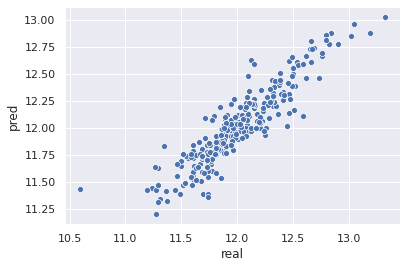

In [31]:
model.corrplot()

In [32]:
model.hetplot()

AttributeError: 'function' object has no attribute 'get'

In [ ]:
pkl_name = "{}.pkl".format(datetime.now().strftime("%Y-%b-%d-%H-%M-%S"))

In [ ]:
pickle.dump(best_model, open("models/" + pkl_name, 'wb'))

In [ ]:
y_pred_train = best_model.predict(X_train)

In [ ]:
mean_squared_error_train = mean_squared_error(y_train, y_pred_train)
mean_squared_error_train

### Avaliação de overfitting

In [ ]:
y_pred_valid = best_model.predict(X_valid)

In [ ]:
mean_squared_error_valid = mean_squared_error(y_valid, y_pred_valid)
mean_squared_error_valid

### Register Experiment

In [ ]:
PARAMS = {"dataprep": dataprep_list,
          "grid_search": parameters}

In [ ]:
experiment_name = "new features"

In [ ]:
neptune.create_experiment(name=experiment_name, params=PARAMS)

In [ ]:
neptune.log_artifact("models/" + pkl_name)

In [ ]:
neptune.log_metric('mean_squared_error_train',mean_squared_error_train)
neptune.log_metric('mean_squared_error_valid', mean_squared_error_valid)

### Avaliação dos resíduos

In [ ]:
residues = pd.DataFrame()
residues["real"] = y_valid
residues["pred"] = y_pred_valid

In [ ]:
residuePlot = sns.scatterplot(x="real", y="pred", data=residues)
fig = residuePlot.get_figure()

In [ ]:
neptune.log_image('residues', fig)

### Predição do conjunto de teste

In [ ]:
X_test = feature_eng(test, dataprep_list)

In [ ]:
X_test.columns

In [ ]:
y_pred_test = best_model.predict(X_test)

In [ ]:
y_pred_test_transform = target_eng(y_pred_test, target_column = target_column, inverse = True)

In [ ]:
predictions = KaggleSubmission()

In [ ]:
predictions["Id"] = test.Id
predictions["SalePrice"] = y_pred_test_transform

In [ ]:
predictions.save('house-prices-advanced-regression-techniques', "Id", "SalePrice")

predictions.submit(message = "featureeng melhorada")

neptune.log_metric('mean_squared_error_test', 0.15738)